### Projeto Final de Spark - Visualizações - Nível Avançado

In [1]:
%%capture
!pip install elasticsearch
!pip install --upgrade requests

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importação de client python para consultar dados em uma aplicação Elastic
from elasticsearch import Elasticsearch

In [3]:
# Criado uma instância do client com as configurações de endereço e credenciais para consultar a base de dados
es = Elasticsearch(\
                   'https://imunizacao-es.saude.gov.br:443',\
                   basic_auth=('imunizacao_public', 'qlto5t&7r_@+#Tlstigi')\
                  )

In [4]:
# Criação da query para buscar a quantidade de vacinas aplicadas no último ano (365 dias) no Brasil
query = ({
    'bool': {
      'must': [
        {
          'bool': {
            'must_not': [
              {
                'exists': {
                  'field': 'dt_deleted'
                }
              }
            ]
          }
        },
        {
          'range': {
            'vacina_dataAplicacao': {
              'gte': '2020-01-01',
              'format': 'yyyy-MM-dd'
            }
          }
        }
      ]
    }
  })

aggs = ({
    'vacina_por_dia': {
      'date_histogram': {
        'field': 'vacina_dataAplicacao',
        'calendar_interval': 'day',
        'order': {
            '_key': 'asc'
        }
      },
      'aggs': {
        'vacina_por_dia_acumulado': {
            'cumulative_sum': {
                'buckets_path': '_count',
            }
        }
      }
    },
    'total_by_uf': {
        'terms': {
            'field': 'estabelecimento_uf',
            'size': 30,
        }
    }
  })

# Realização da busca ao dados na aplicação Elastic
resp = es.search(index="", query=query, size=0, aggs=aggs)

In [5]:
# Criação de dicionários a partir do resutado da busca. Esses dicionários serão utilizados para criar dataframes
# Pandas, que serão usados para criar visualizações com os dados retornados pela aplicação
vacina_por_dia = []
vacina_por_uf = []

for idx, reg_por_dia in enumerate(resp['aggregations']['vacina_por_dia']['buckets']):
    vacina_por_dia.append({\
                          'data': reg_por_dia['key_as_string'],\
                          'vacina_qtd': reg_por_dia['doc_count'],\
                          'vacina_qtd_acumulado': reg_por_dia['vacina_por_dia_acumulado']['value']})
    

for idx, reg_por_uf in enumerate(resp['aggregations']['total_by_uf']['buckets']):
    vacina_por_uf.append({\
                          'UF': reg_por_uf['key'],\
                          'vacina_qtd': reg_por_uf['doc_count']})

## Total de vacinas aplicadas por estado

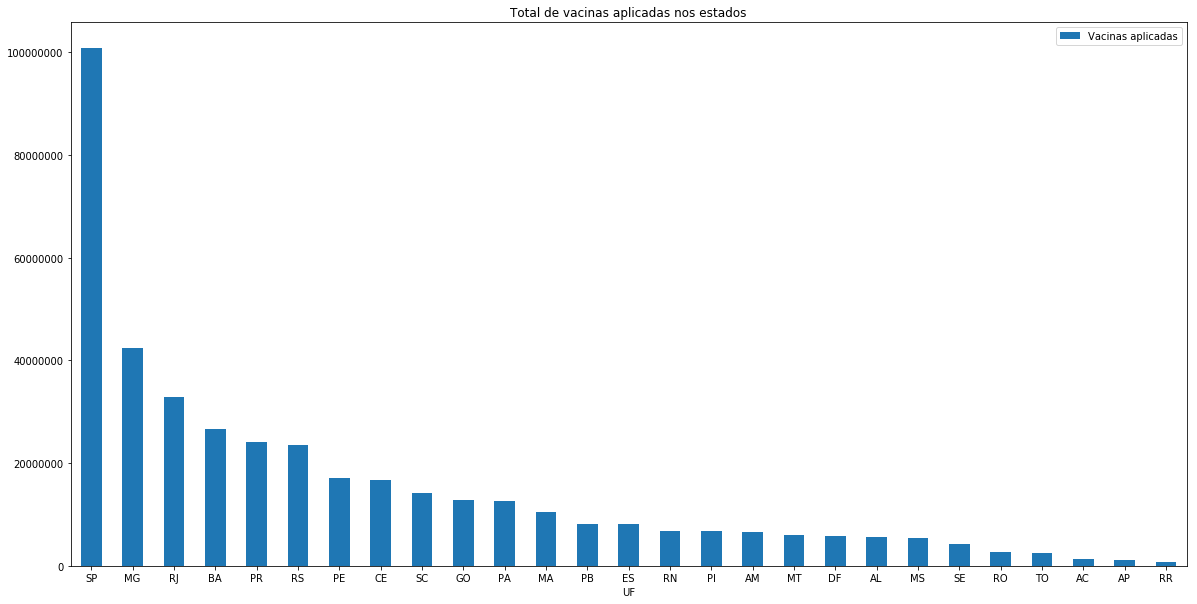

In [6]:
# Criação e adequação do dataframe para a criação da visualização de vacinas aplicadas nos estados
df = pd.DataFrame.from_dict(vacina_por_uf)
df['Vacinas aplicadas'] = df['vacina_qtd']

# Criação e configuração dos objetos utilizados para criação da visualização
fig, ax = plt.subplots(1, 1)
ax.ticklabel_format(style='plain')
df.plot.bar(x='UF', y='Vacinas aplicadas',\
            figsize=(20,10),\
            title='Total de vacinas aplicadas nos estados',\
            rot=0,\
            ax=ax);

## Quantidade de vacinas aplicadas por dia no Brasil

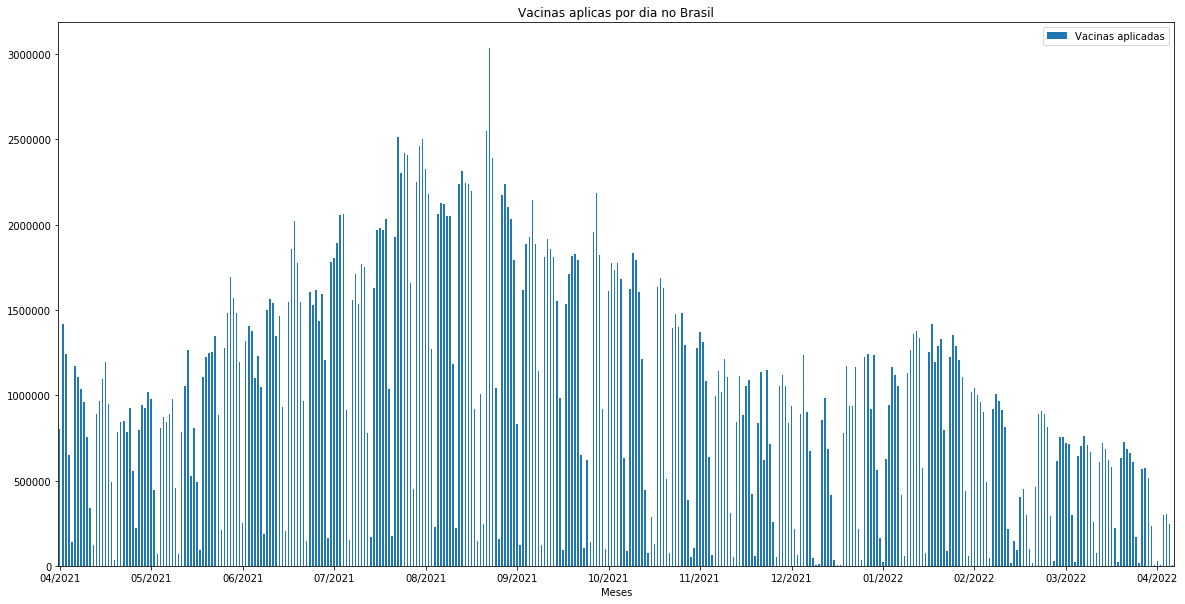

In [7]:
# Criação e adequação do dataframe para a criação da visualização de Vacinas aplicadas por dia no Brasil
df = pd.DataFrame.from_dict(vacina_por_dia)[-366:]
df['Meses'] = pd.to_datetime(df['data']).dt.strftime('%m/%Y')
df['Vacinas aplicadas'] = df['vacina_qtd']
lista_indices = np.arange(0, len(df['Meses']) - 1, 30)
lista_indices_label = np.take(df['Meses'], lista_indices).to_list()

# Criação e configuração dos objetos utilizados para criação da visualização
fig, ax = plt.subplots(1, 1)
ax.ticklabel_format(style='plain')
df.plot.bar(x='Meses', y='Vacinas aplicadas',\
            figsize=(20,10),\
            title='Vacinas aplicas por dia no Brasil',\
            rot=0,\
            ax=ax)
ax.set_xticks(lista_indices)
ax.set_xticklabels(lista_indices_label);

## Quantidade acumulada de vacinas aplicadas no Brasil

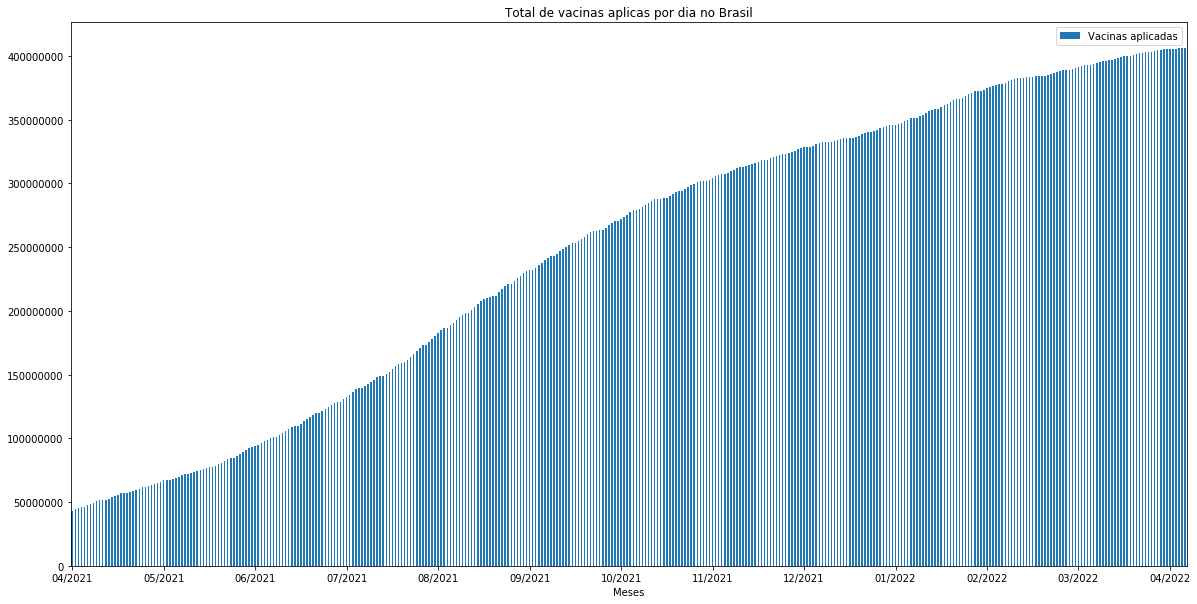

In [8]:
# Criação e adequação do dataframe para a criação da visualização de total de vacinas aplicadas por dia no Brasil
df['Vacinas aplicadas'] = df['vacina_qtd_acumulado']

# Criação e configuração dos objetos utilizados para criação da visualização
fig, ax = plt.subplots(1, 1)
ax.ticklabel_format(style='plain')
df.plot.bar(x='Meses', y='Vacinas aplicadas',\
            figsize=(20,10),\
            title='Total de vacinas aplicas por dia no Brasil',\
            rot=0,\
            ax=ax)
ax.set_xticks(lista_indices)
ax.set_xticklabels(lista_indices_label);

In [9]:
# Criação da query para buscar a quantidade de vacinas aplicadas no último ano (365 dias) no estado do ES
query = ({
    'bool': {
      'must': [
        {
          'bool': {
            'must_not': [
              {
                'exists': {
                  'field': 'dt_deleted'
                }
              }
            ],
            'filter':{
                'term': {'estabelecimento_uf':'ES'}
            }
          }
        },
        {
          'range': {
            'vacina_dataAplicacao': {
              'gte': '2020-01-01',
              'format': 'yyyy-MM-dd'
            }
          }
        }
      ]
    }
  })

aggs = ({
    'vacina_por_dia': {
      'date_histogram': {
        'field': 'vacina_dataAplicacao',
        'calendar_interval': 'day',
        'order': {
            '_key': 'asc'
        }
      },
      'aggs': {
        'vacina_por_dia_acumulado': {
            'cumulative_sum': {
                'buckets_path': '_count',
            }
        }
      }
    }
  })

# Realização da busca ao dados na aplicação Elastic
resp = es.search(index="", query=query, size=0, aggs=aggs)

In [10]:
# Criação de dicionários a partir do resutado da busca. Esses dicionários serão utilizado para criar um dataframe
# Pandas e criar visualizações com os dados retornados pela aplicação

vacina_por_dia = []

for idx, reg_por_dia in enumerate(resp['aggregations']['vacina_por_dia']['buckets']):
    vacina_por_dia.append({\
                          'data': reg_por_dia['key_as_string'],\
                          'vacina_qtd': reg_por_dia['doc_count'],\
                          'vacina_qtd_acumulado': reg_por_dia['vacina_por_dia_acumulado']['value']})

## Quantidade de vacinas aplicadas por dia no estado do ES

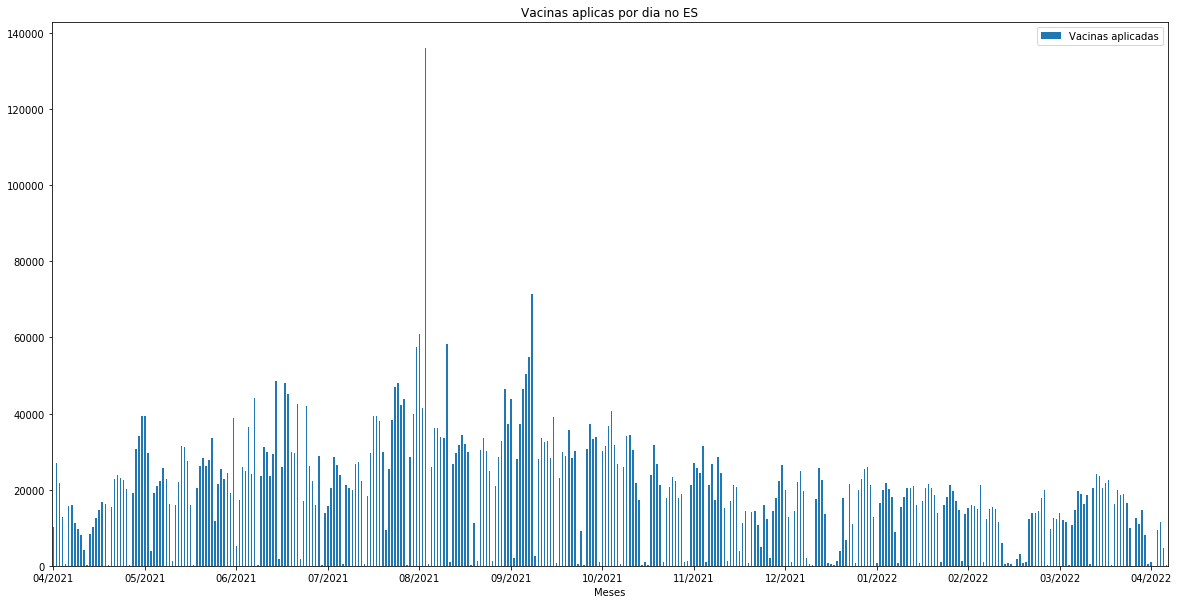

In [11]:
# Criação e adequação do dataframe para a criação da visualização de Vacinas aplicadas por dia no Brasil
df = pd.DataFrame.from_dict(vacina_por_dia)[-366:]
df['Meses'] = pd.to_datetime(df['data']).dt.strftime('%m/%Y')
df['Vacinas aplicadas'] = df['vacina_qtd']
lista_indices = np.arange(0, len(df['Meses']) - 1, 30)
lista_indices_label = np.take(df['Meses'], lista_indices).to_list()

# Criação e configuração dos objetos utilizados para criação da visualização
fig, ax = plt.subplots(1, 1)
ax.ticklabel_format(style='plain')
df.plot.bar(x='Meses', y='Vacinas aplicadas',\
            figsize=(20,10),\
            title='Vacinas aplicas por dia no ES',\
            rot=0,\
            ax=ax)
ax.set_xticks(lista_indices)
ax.set_xticklabels(lista_indices_label);

## Quantidade acumulada de vacinas aplicadas no ES

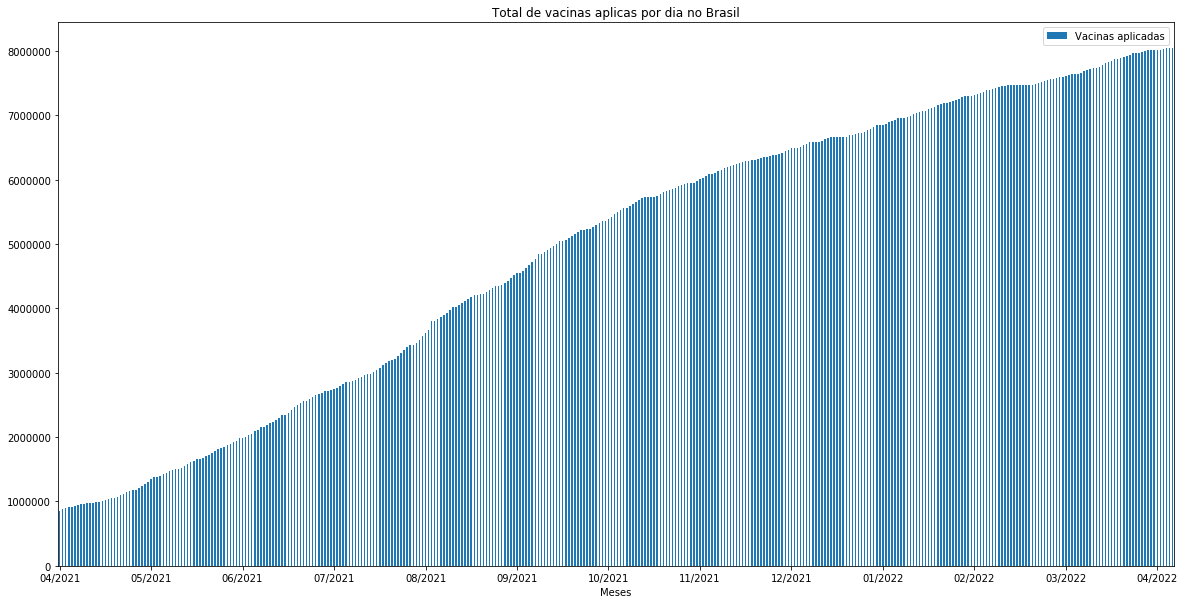

In [12]:
# Criação e adequação do dataframe para a criação da visualização de total de vacinas aplicadas por dia no Brasil
df['Vacinas aplicadas'] = df['vacina_qtd_acumulado']

# Criação e configuração dos objetos utilizados para criação da visualização
fig, ax = plt.subplots(1, 1)
ax.ticklabel_format(style='plain')
df.plot.bar(x='Meses', y='Vacinas aplicadas',\
            figsize=(20,10),\
            title='Total de vacinas aplicas por dia no Brasil',\
            rot=0,\
            ax=ax)
ax.set_xticks(lista_indices)
ax.set_xticklabels(lista_indices_label);